# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [7]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
%matplotlib inline
### Storing the parameters of the line found in earlier video frames. The line parameters estimated for current 
### frame is avereged with the earlier parameters to create  lane  lines that appear smooth in the video.
### If not averaged the lines seems bit shaky in the video.
left_lines = []  # stores (slope,intercept) of extrapolated lines in the left lane.
right_lines= []  # stores (slope,intercept) of extrapolated lines in the right lane
size = 30 # maximun size of the above two lists
clr_msk=False # Flag that control whether to apply color mask or not

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


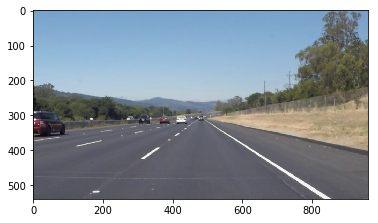

In [8]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [9]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def get_lanes(lines):
    """
    function that determines the line parameters for left and right lanes. The line segments are seperated on the basis
    of slope. Line segments in the left lane have negative slope (y decreases as x increases) and line segments in the
    right lane are positively sloped (y increases as x increases). Also, every line segment is assigned a weight-value,
    on the basis of its length. Longer line segments are given are higher weights. Assigning weights to line segments
    helps in diminishing the effect of spurious short line segments when determining the line parameters for any lane.
    """

    left = [] # list store the parameters (slope,intercept) for line segments identified to be in left lane
    left_wt = [] # list corresponding to above list and stores the weights of the line segments identified in left lane
    right= [] # list store the parameters (slope,intercept) for line segments identified to be in right lane 
    right_wt=[] # list corresponding to above list and stores the weights of the line segments identified in right lane
    
    for line in lines: # iterate over line segments in the image
        x1,y1,x2,y2=line[0]
        if x2-x1 != 0:
            slp = (y2-y1)/(x2-x1)  # calculate slope, slope -> (y2-y1)/(x2-x1)
            inc = y2-slp*x2        # calculate intercept, y = slope*x+intercept ----> intercept = y-(slope*x) 
            if slp < 0:            # line segment in left lane, if slope is negative
                left.append([slp,inc])
                dist = ((y2-y1)**2)+((x2-x1)**2)    # weight is the eucledian length of the line segment
                left_wt.append(np.sqrt(dist))
            elif slp > 0:          # line segment in right lane if slope is positive
                right.append([slp,inc])
                dist = ((y2-y1)**2)+((x2-x1)**2)
                right_wt.append(np.sqrt(dist))
    
    ### Calculate the parameters for extrapolating line over the line segments. The parameters are calculated as
    ### weighted average over the parameters of identified line segments in left and right lane respectively.
    avg_left = np.average(left,axis=0,weights=left_wt)
    avg_right = np.average(right,axis=0,weights=right_wt)
    
    return avg_left, avg_right

def get_line_coordinates(lane,min_y,max_y):
    """
    Function take input as left or right lane parameters (slope,intercept) as lane 
    and minimum and maximum values of y coordinates.
    Function return the corresponding x  coordinate values using lane 
    parameters.
    """
    slp,inc = lane # parameters
    start_y = int(min_y) # y value at bottom of image
    start_x = int((start_y-inc)/slp) # corresponding x-coordinate value
    end_y = int(max_y) # y-coordinate value below range of vision
    end_x = int((end_y-inc)/slp) # corresponding y-coordinate value
    res = [start_x,start_y,end_x,end_y] 
    return res
  

def draw_lines(img, lines,flag, color=[255, 0, 0], thickness=8):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    
    ### if flag value equals 'default' the only draw line segments identified using hough lines,   
    ### otherwise extrapolate lines over line segments.
    if flag == 'default':
        for line in lines:
            x1,y1,x2,y2 = line[0]
            cv2.line(img, (x1,y1), (x2,y2), color, thickness)
        return
                
    
    
    ### get the parameters to extrapolate line over line segments for left and right lane respectively.
    left,right = get_lanes(lines)
    
    
    ### Appending current parameters to the list of line parameters identified in previous video frames.
    if len(left_lines) < size:
        left_lines.append(left)
    else:
        left_lines.pop(0)
        left_lines.append(left)
        
    if len(right_lines) < size:
        right_lines.append(right)
    else:
        right_lines.pop(0)
        right_lines.append(right)
     
    ### Averaging over the parametres for left and right lane respectively. Avereged parameters over earlier frames
    ### are used to draw lines in the image that will appear smooth over continuous frames.
    lanes = [np.mean(left_lines,axis=0),np.mean(right_lines,axis=0)]
    
    ### Determine coordinates using line parameters calculated above
    ### y-coordinate value are used to calculate the x coordinate values.
    ### y-coordinate value for the bottom of the line is = image.shape[0] --- bottom of the image
    ### y-coordinate value for the top of the line is = image.shape[0]*0.65 --- below the field of vision
    lane_coordinates = [get_line_coordinates(lanes[0],img.shape[0],img.shape[0]*0.65),get_line_coordinates(lanes[1],img.shape[0],img.shape[0]*0.65)]       
    
    ### Draw the line
    for line in lane_coordinates:
        x1,y1,x2,y2 = line
        cv2.line(img, (x1,y1), (x2,y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap,flag):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines,flag=flag)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [10]:
import os
os.listdir("test_images/")

['whiteCarLaneSwitch.jpg',
 'solidYellowLeft.jpg',
 'solidWhiteRight.jpg',
 'solidWhiteCurve.jpg',
 'solidYellowCurve2.jpg',
 '.ipynb_checkpoints',
 'solidYellowCurve.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

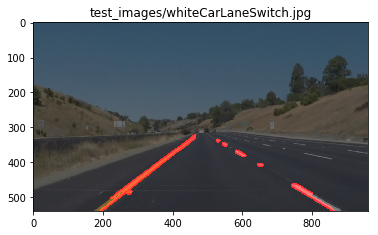

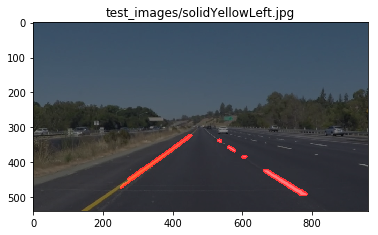

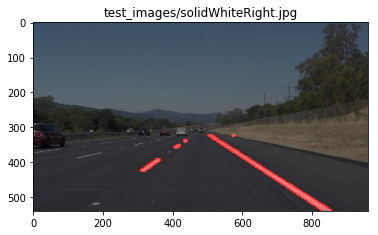

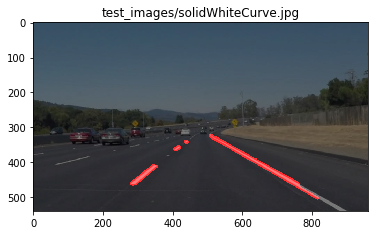

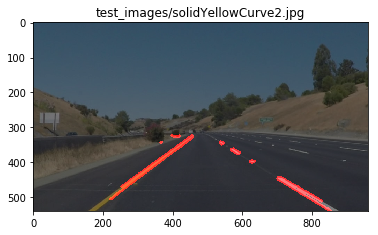

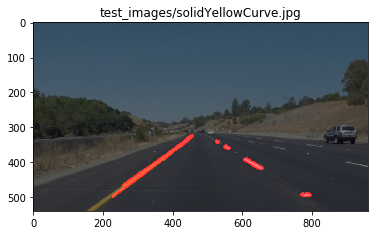

In [12]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images_output directory.

def get_threshold(blr_image):
    """
    Function the takes input as gaussian smoothe grayscale image and outputs the low and high threshold values
    to be used in canny edge detection.
    
    It follows the method used in canny edge detection for calculating the gradient using sobel filter.
    The 25th and 50th percentile calculated over unique values of gradient matrix is used as the low and high
    threshold values.
    """
    sobelx = cv2.Sobel(blr_image,cv2.CV_64F,1,0,ksize=3) ## calculating gradient in x direction using sobel filter
    sobely = cv2.Sobel(blr_image,cv2.CV_64F,0,1,ksize=3) ## calculating gradient in y direction using soble filter
    grad = abs(sobelx)+abs(sobely) ## overall gradient as calcualted in Canny algorithm is the sum of the absolute values
    unique, counts = np.unique(grad.flatten(), return_counts=True) ## Determining unique gradient values
    high = np.median(unique)
    low = np.median(unique[unique<high])
    return low, high

def color_mask(img):
    """
    Function applies yellow and white color mask over the original image, to identifu yellow and white color lanes.
    Mostly helpful in the last challenge video, where edge detection is bit difficult in bright sunlight in RGB color space.
    So the mask is applied in HLS color space in which the lane markings are quite distinguishable.
    """
    hls_img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS) # convert to HLS color space
    ##upper and lower limit for the white color mask, the range is determine by hit and trial and color picker
    upper_limit = np.array([255,255,255])
    lower_limit = np.array([0,200,0])
    white = cv2.inRange(hls_img,lower_limit,upper_limit) ## white color mask
    ## upper and lower limit for yeloow color mask, for yellow shade the hue is between 10 and 40, other parameters are
    ## determined by hit and trial and color picker
    lower_limit = np.array([10,0,100])
    upper_limit = np.array([40,255,255])
    yellow = cv2.inRange(hls_img,lower_limit,upper_limit) ## mask for yellow color
    mask = cv2.bitwise_or(white,yellow) ## White and yellow color mask combined
    res = cv2.bitwise_and(img,img,mask=mask) ## applying mask to the image
    return res

### Main pipeline function for detecting lanes and drawing lane lines. If flag equals 'default' it will draw line segments 
### Otherwise it will draw complete lines.
### Vertices define the Region of Interest
### test_img is the original image (as numpy array)
### Other are HoughLine parameters
def detect_lanes(test_img,vertices,rho,theta,threshold,min_line_len,max_line_gap,flag):
    if clr_msk:
        color_masked_img = color_mask(test_img)
    else:
        color_masked_img = test_img
    gray = grayscale(color_masked_img) # Convert to grayscale
    blur_gray = gaussian_blur(gray,7) # Smooth the image using 3x3 gaussian filter
    low,high = get_threshold(blur_gray)
    edges = canny(blur_gray,low,high) # Detecting edges in the blurred image, low_threshold=100, high_threshold=200
    masked_edges = region_of_interest(edges, vertices) # Consider edges only in region of interest
    # Draw lines using edges using hough transform
    line_image = hough_lines(masked_edges, rho=rho, theta=theta, threshold=threshold, min_line_len=min_line_len, max_line_gap=max_line_gap,flag=flag)
    lines_edges= weighted_img(line_image, test_img, α=0.5, β=1., γ=0) # Combine original image with the line image
    plt.imshow(lines_edges) # Display the image
    return lines_edges # return the combined image

### Iterate over the test images, for each image detect and display the detecte4d line segments
for image in glob.glob("test_images/*.jpg"):
    left_lines=[]
    right_lines=[]
    plt.figure() # Draw each image in seperate figures
    plt.title(image) # Title of each image --- its filename
    test_img = mpimg.imread(image) # Rading the image
    imshape = test_img.shape # shape of the numpy array
    ## Defining the region of interest as numpy array of vertices
    vertices = np.array([[(imshape[1]*0.2,imshape[0]),(imshape[1]*0.4,imshape[0]*0.6),(imshape[1]*0.6,imshape[0]*0.6), (imshape[1]*0.9,imshape[0])]], dtype=np.int32)
    ## Detecting the line segments using the main pipeline function and various tuned HoughLine parameters
    line_edges = detect_lanes(test_img,vertices,rho=1, theta=(np.pi)*1/180, threshold=5, min_line_len=1, max_line_gap=1,flag='default')
    cv2.imwrite("test_images_output/"+image,line_edges) # saving the image


## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [13]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [14]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    #test_img = mpimg.imread(image)
    imshape = image.shape
    vertices = np.array([[(imshape[1]*0.2,imshape[0]),(imshape[1]*0.4,imshape[0]*0.6),(imshape[1]*0.6,imshape[0]*0.6), (imshape[1]*0.9,imshape[0])]], dtype=np.int32)
    result = detect_lanes(image,vertices,rho=1, theta=(np.pi)*1/180, threshold=5, min_line_len=1, max_line_gap=1,flag='line')
    return result

## The Setup
**The Line in the below video are drawn without using any color mask, As it will be seen that without using any color mask doesn't do well in the case of challenge video. Same set of videos will be used with color mask, and better results will be obtained**

Let's try the one with the solid white lane on the right first ...

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:26<00:00,  7.94it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 13.2 s, sys: 2.87 s, total: 16.1 s
Wall time: 27.7 s


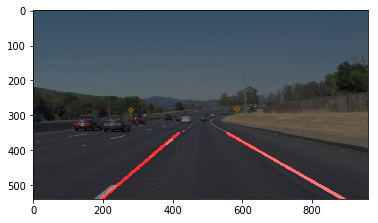

In [15]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
left_lines=[]
right_lines=[]
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [16]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|█████████▉| 681/682 [01:22<00:00,  8.19it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 39.8 s, sys: 9.37 s, total: 49.2 s
Wall time: 1min 24s


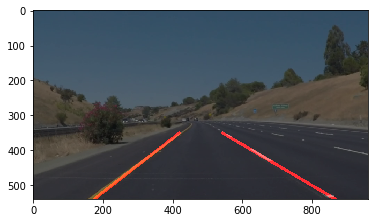

In [17]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
left_lines=[]
right_lines=[]
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

In [18]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|██████████| 251/251 [00:55<00:00,  4.80it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 27 s, sys: 4.06 s, total: 31 s
Wall time: 58.4 s


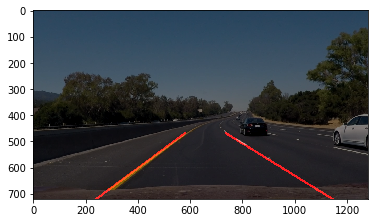

In [19]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
left_lines=[]
right_lines=[]
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [20]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

## Results -- without color mask
**As stated earlier the pipeline did a fair job in drawing lane lines in the first two videos but it doesn't do well enough in the challenge video. So, now the pipeline will use a color mask for white and yellow colors, other things in pipeline will remain exactly the same as earlier. The new results for each video are below** 

## Color mask

**The color mask is applied in HSL color space. Color mask in RGB colorspace was not clearlt detecting the yellow color where there was a bright sunlight in shallenge video, and in HSL color space the yellow and white lines were very distinguishable. So the color mask is applied in the HSL colorspace. Some of the snapshots in HSL color space are shown below**

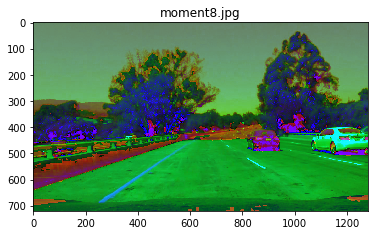

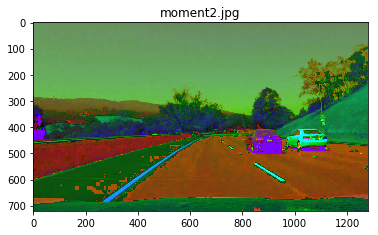

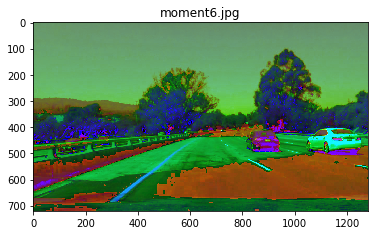

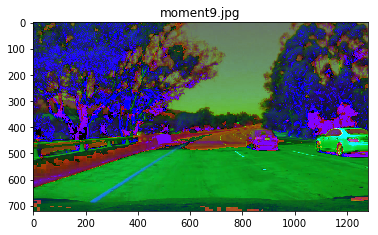

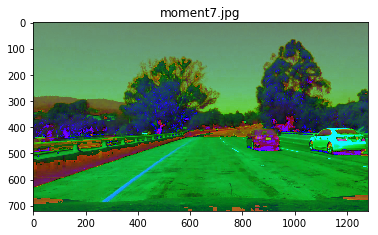

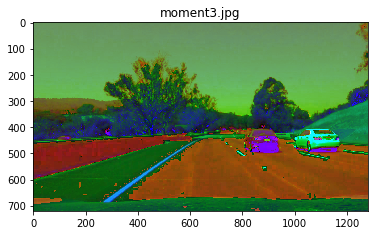

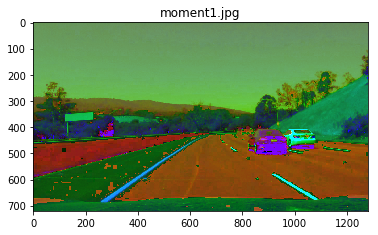

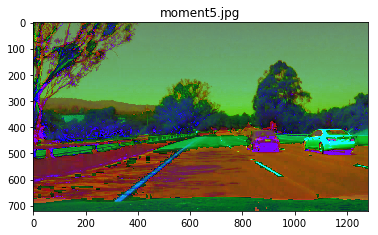

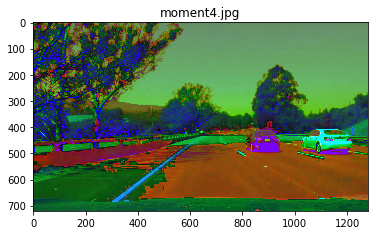

In [21]:
for image in os.listdir("challenge_video_snapshots/"):
    plt.figure()
    plt.title(image)
    snap = mpimg.imread("challenge_video_snapshots/"+image)
    out = cv2.cvtColor(snap,cv2.COLOR_RGB2HLS)
    plt.imshow(out)

**Results with colormask are shown below**

[MoviePy] >>>> Building video test_videos_output/Masked_solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/Masked_solidYellowLeft.mp4


100%|█████████▉| 681/682 [01:13<00:00,  9.26it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/Masked_solidYellowLeft.mp4 

CPU times: user 38.7 s, sys: 1.41 s, total: 40.1 s
Wall time: 1min 15s


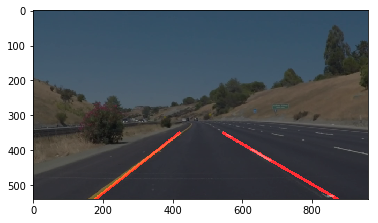

In [22]:
clr_msk = True
yellow_output = 'test_videos_output/Masked_solidYellowLeft.mp4'
left_lines=[]
right_lines=[]
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

In [23]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

[MoviePy] >>>> Building video test_videos_output/Masked_challenge.mp4
[MoviePy] Writing video test_videos_output/Masked_challenge.mp4


100%|██████████| 251/251 [00:55<00:00,  4.95it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/Masked_challenge.mp4 

CPU times: user 26.5 s, sys: 3.76 s, total: 30.3 s
Wall time: 57.9 s


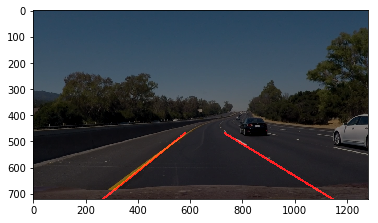

In [24]:
challenge_output = 'test_videos_output/Masked_challenge.mp4'
left_lines=[]
right_lines=[]
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [25]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

### Reflection

The pipeline has the following steps:
* **Color Masking:** This is an optional step. First, the results are obtained without applying the color mask. The results are 
for the exercise videos. But the pipeline without color masking performs poorly on challenge video. In second part the results are
obtained with color mask.
The color mask detects yellow and white color in HSL color space. The HSL color space is used as white and yellow color lanes are very
distinguishable in HSL color space in bright sunlight and shadows.

* **Gray Scaling:** The image obtained after above optional step the color image is converted to gray scale.

* **Gaussian Blur:** The image is smoothed using a Gaussian smoothing filter, this step will smooths out any rough edges in the image and it will not appear during Canny edge detection

* **Edge Detection:** Canny edge detection is applied to detect edges in the blurred image. A helper function is also created that adaptively determine low and high thresholds of gradient which will be used in Canny edge detection.

* **Region Masking:** The above step will detect edges in complete image, to focus on the region where the lane markings a region mask is created and applied on the image.

* **Finding Line Segments:** From edges form line segments using *HoughLinesP* method of opencv. Several parameters are need to be set for the fucntion to work well. Draw line segments using *draw_lines()* function.

* **Combining:** The line segments image is combined with original image to produce final result.

Modification to *draw_lines()* function to extrapolate line:

* **Seperating line segments:** The line segments are seperated as belonging to left lane and right lane based on their slope values. Positively sloped line segments belong to right lane and negatively sloped line segments belong to left lane.

* **Calculating parameters and weights:** For each line segment, its parameter values (slope,intercept) and its weight value are calculated.
Weight of a line segment is an increasing function of its eucledian length. The results are stored in a list.

* **Extrapolated line parameters:** The parameters (slope,intercept) for the extrapolated line for left and right lane are calculated as weighted average of the line segments parameters with the weights  and corresponding parameters calculated in previous step.

* **Adding to the frame list:** The parameters for extrapolated line obtained for left and right lane respectively are added to the previous frame list that stores the similar parameters from previous video frames.

* **Averaging over frame list:** To draw left and right lane lines, the parameters for the corresponding lane is obtained by averaging over the frame list modified above. This step and the previous step help in drawing line over frame that looks smooth frame by frame, by smoothing any minor jerks in the line parameters.

* **Drawing line:** Finally the lines are drawn using the avereged parameters obtained above. The y-coordinate values are chosen and corresponding x-coordinate values are obtained using the parameters determined above.

### 2.Shortcomings

I believe this is very basic lane detection mechanism and needs improvement:

* **Color Mask:** In the second part of the work to do well on the challenge video I have used a color mask for detecting yellow and white lane markings. It was a struggle to find the approriate color range. The pipeline is sensitive to color range. In different lighting condition it may not work very well.
* **Fitting Straight Lines:** Strainght line are fitted for the lanes, this pipeline will fail to detect the curvature of lane markings that will result in poor result.

* **Traffic:** If there is lot of traffic on the road it may affect the result, especially if the vehicles ahead are covering the lane markings the result will not be very good.


### 3. Improvements

Improvements:
 
 * **Non linear polynomials:** Instead of fitting straight lines, several non linear polynomials can be tried and based on the value of residuals appropriate degree polynomial can be chosen to represent the lane markings.
 * **Adaptive parameters selection:** For hough transform the parameters were determined by hit and trial method, adaptive strategy can be designed to determine the parameters to be used. 